# Import packages

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 500)
from scipy.stats import levy_stable

from datetime import datetime
from scipy.stats import kstest
from scipy.stats import jarque_bera
# from arch.unitroot import ADF
from scipy.stats import kurtosis
from scipy.stats import skew
# from arch import arch_model

import pickle

import ta

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import webbrowser
from datetime import datetime, timedelta

import random

plt.style.use('classic')
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 300)

# %config inlinebackend.figure_format = 'svg'

In [2]:
import sys

sys.path.insert(0, 'D:/Intraday_trading')

In [3]:
from src.support import *
from src.backtest import *
from src.models import *
from src.models_support import *

# Import and pre-processing data

## Interval data

In [4]:
%%time

interval_data = pd.read_pickle('D:/Intraday_trading/Training/Data/XAUUSD_M15_1.pkl')

interval_data = interval_data.set_index('DATE_TIME')
interval_data.index = pd.to_datetime(interval_data.index)

interval_data['DATE'] = pd.to_datetime(interval_data['DATE'])
interval_data['OPEN'] = interval_data['OPEN']
interval_data['HIGH'] = interval_data['HIGH']
interval_data['LOW'] = interval_data['LOW']
interval_data['CLOSE'] = interval_data['CLOSE']


CPU times: total: 31.2 ms
Wall time: 19.3 ms


### Prepare_df

In [5]:
df_4_hour = prepare_df(df = interval_data, timeframe = '4H', add_indicators = True)
df_1_day = prepare_df(df = interval_data, timeframe = '1D', add_indicators = True)
df_15_min = prepare_df(df = interval_data, timeframe = '15min', add_indicators = True)

df_1_day['WHOLE_RANGE'] = df_1_day['HIGH'] - df_1_day['LOW']
df_4_hour['WHOLE_RANGE'] = df_4_hour['HIGH'] - df_4_hour['LOW']
df_15_min['WHOLE_RANGE'] = df_15_min['HIGH'] - df_15_min['LOW']

df_1_day['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day['WHOLE_RANGE'], 10)
df_4_hour['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour['WHOLE_RANGE'], 10)
df_15_min['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min['WHOLE_RANGE'], 10)

df_1_day['GRP_BODY'] = pd.qcut(df_1_day['BODY'], 10)
df_4_hour['GRP_BODY'] = pd.qcut(df_4_hour['BODY'], 10)
df_15_min['GRP_BODY'] = pd.qcut(df_15_min['BODY'], 10)

df_1_day['YEAR'] = df_1_day.index.strftime('%Y')
df_1_day['WEEK'] = df_1_day.index.strftime('%Y%W')
df_1_day['MONTH'] = df_1_day.index.strftime('%Y%m')

df_4_hour['YEAR'] = df_4_hour.index.strftime('%Y')
df_4_hour['WEEK'] = df_4_hour.index.strftime('%Y%W')
df_4_hour['MONTH'] = df_4_hour.index.strftime('%Y%m')

df_15_min['YEAR'] = df_15_min.index.strftime('%Y')
df_15_min['WEEK'] = df_15_min.index.strftime('%Y%W')
df_15_min['MONTH'] = df_15_min.index.strftime('%Y%m')



In [6]:
df_15_min.shape, df_4_hour.shape, df_1_day.shape, 

((99741, 36), (6783, 36), (1311, 36))

In [7]:
df_1_day.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICK_VOL', 'AVG_PRICE',
       'FLAG_INCREASE_CANDLE', 'BODY', 'UPPER_SHADOW', 'LOWER_SHADOW',
       'WHOLE_RANGE', 'FLAG_LONG_UPPER_SHADOW', 'FLAG_LONG_LOWER_SHADOW',
       'FLAG_HIGHER_HIGH(20)', 'FLAG_HIGHER_LOW(20)', 'AVG_VOL(50)',
       'FLAG_OVER_AVG_VOL(50)', 'AVG_VOL(200)', 'FLAG_OVER_AVG_VOL(200)',
       'FLAG_UPTREND_VOL(20)', 'RSI', 'FLAG_UNDER_30_RSI', 'FLAG_OVER_70_RSI',
       'FLAG_UPTREND_RSI(20)', 'BB_UPPER_BAND(50)', 'BB_LOWER_BAND(50)',
       'EMA(50)', 'POSITION_EMA(50)', 'EMA(200)', 'POSITION_EMA(200)',
       'Ret(t)', 'GRP_WHOLE_RANGE', 'GRP_BODY', 'YEAR', 'WEEK', 'MONTH'],
      dtype='object')

In [8]:
# df_15_min.index[0], df_15_min.index[-1]

In [9]:
# plot_df(df_1_day, 
#         path = None,# 'D:/Intraday_trading/Training/Saved_results/plot_df.html', 
#         open_tab = False)

# Strategy

In [10]:
interval_is = interval_data[interval_data.index < datetime(2023, 1, 1)]
interval_os = interval_data[interval_data.index >= datetime(2023, 1, 1)]


In [11]:
df_4_hour_is = prepare_df(df = interval_is, timeframe = '4H', add_indicators = False)
df_1_day_is = prepare_df(df = interval_is, timeframe = '1D', add_indicators = False)
df_15_min_is = prepare_df(df = interval_is, timeframe = '15min', add_indicators = False)

df_1_day_is['WHOLE_RANGE'] = df_1_day_is['HIGH'] - df_1_day_is['LOW']
df_4_hour_is['WHOLE_RANGE'] = df_4_hour_is['HIGH'] - df_4_hour_is['LOW']
df_15_min_is['WHOLE_RANGE'] = df_15_min_is['HIGH'] - df_15_min_is['LOW']

df_1_day_is['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day_is['WHOLE_RANGE'], 10)
df_4_hour_is['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour_is['WHOLE_RANGE'], 10)
df_15_min_is['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min_is['WHOLE_RANGE'], 10)

df_1_day_is['GRP_BODY'] = pd.qcut(df_1_day_is['BODY'], 10)
df_4_hour_is['GRP_BODY'] = pd.qcut(df_4_hour_is['BODY'], 10)
df_15_min_is['GRP_BODY'] = pd.qcut(df_15_min_is['BODY'], 10)

df_1_day_is['YEAR'] = df_1_day_is.index.strftime('%Y')
df_1_day_is['WEEK'] = df_1_day_is.index.strftime('%Y%W')
df_1_day_is['MONTH'] = df_1_day_is.index.strftime('%Y%m')
df_1_day_is['DATE'] = df_1_day_is.index.strftime('%Y%m%d')

df_4_hour_is['YEAR'] = df_4_hour_is.index.strftime('%Y')
df_4_hour_is['WEEK'] = df_4_hour_is.index.strftime('%Y%W')
df_4_hour_is['MONTH'] = df_4_hour_is.index.strftime('%Y%m')
df_4_hour_is['DATE'] = df_4_hour_is.index.strftime('%Y%m%d')

df_15_min_is['YEAR'] = df_15_min_is.index.strftime('%Y')
df_15_min_is['WEEK'] = df_15_min_is.index.strftime('%Y%W')
df_15_min_is['MONTH'] = df_15_min_is.index.strftime('%Y%m')
df_15_min_is['DATE'] = df_15_min_is.index.strftime('%Y%m%d')

#-----------------------------------------------------

df_4_hour_os = prepare_df(df = interval_os, timeframe = '4H', add_indicators = False)
df_1_day_os = prepare_df(df = interval_os, timeframe = '1D', add_indicators = False)
df_15_min_os = prepare_df(df = interval_os, timeframe = '15min', add_indicators = False)

df_1_day_os['WHOLE_RANGE'] = df_1_day_os['HIGH'] - df_1_day_os['LOW']
df_4_hour_os['WHOLE_RANGE'] = df_4_hour_os['HIGH'] - df_4_hour_os['LOW']
df_15_min_os['WHOLE_RANGE'] = df_15_min_os['HIGH'] - df_15_min_os['LOW']

df_1_day_os['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day_os['WHOLE_RANGE'], 10)
df_4_hour_os['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour_os['WHOLE_RANGE'], 10)
df_15_min_os['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min_os['WHOLE_RANGE'], 10)

df_1_day_os['GRP_BODY'] = pd.qcut(df_1_day_os['BODY'], 10)
df_4_hour_os['GRP_BODY'] = pd.qcut(df_4_hour_os['BODY'], 10)
df_15_min_os['GRP_BODY'] = pd.qcut(df_15_min_os['BODY'], 10)

df_1_day_os['YEAR'] = df_1_day_os.index.strftime('%Y')
df_1_day_os['WEEK'] = df_1_day_os.index.strftime('%Y%W')
df_1_day_os['MONTH'] = df_1_day_os.index.strftime('%Y%m')

df_4_hour_os['YEAR'] = df_4_hour_os.index.strftime('%Y')
df_4_hour_os['WEEK'] = df_4_hour_os.index.strftime('%Y%W')
df_4_hour_os['MONTH'] = df_4_hour_os.index.strftime('%Y%m')

df_15_min_os['YEAR'] = df_15_min_os.index.strftime('%Y')
df_15_min_os['WEEK'] = df_15_min_os.index.strftime('%Y%W')
df_15_min_os['MONTH'] = df_15_min_os.index.strftime('%Y%m')


In [12]:
df_1_day_is.shape, df_1_day_os.shape

((620, 27), (691, 26))

In [ ]:
class MCMC_strat_v1(Base_Alpha):
    def __init__(self, config):
        super().__init__(
            strat = self._MCMC_strat_v1,
            prepare_data = self._prepare_data
        )

        '''
        config = {
            'base_SL': 10, 
            'base_TP': 20,
            'DECISION_CUTOFF': {'ENTRY_BUY_CUTOFF': 1, 'ENTRY_SELL_CUTOFF': -1}
        }

        Ultilize markov switching regime regression to produce signals
        '''
        self.base_SL = config['base_SL']
        self.base_TP = config['base_TP']
        self.DECISION_CUTOFF = config['DECISION_CUTOFF']
        
        
    def _prepare_data(self, df_observe):
        #returns
        df_observe['RET(T)'] = 100*(df_observe['CLOSE'] - df_observe['CLOSE'].shift(1))/df_observe['CLOSE'].shift(1)
        return(df_observe)

    def _MCMC_strat_v1(self, row):
        if ((row['RET(T)'] > self.DECISION_CUTOFF['ENTRY_BUY_CUTOFF']) & (pd.isnull(row['RET(T)']) == False)):
            return pd.Series([1, self.base_SL, self.base_TP], index=['SIGNAL', 'SL', 'TP']) # Buy signal
        elif ((row['RET(T)'] < self.DECISION_CUTOFF['ENTRY_SELL_CUTOFF']) & (pd.isnull(row['RET(T)']) == False)):
            return pd.Series([-1, self.base_SL, self.base_TP], index=['SIGNAL', 'SL', 'TP']) # Sell signal
        else:
            return pd.Series([0, 0, 0], index=['SIGNAL', 'SL', 'TP']) # No action (neutral)
        



## In sample optimization

In [14]:
config = {
    'base_SL': 10, 
    'base_TP': 20,
    'DECISION_CUTOFF': {'ENTRY_BUY_CUTOFF': 0.5, 'ENTRY_SELL_CUTOFF': -0.5}
}

alpha = MCMC_strat_v1(config = config)

In [15]:
df_15_min_is.shape

(47280, 27)

In [16]:
# cnt = 0

# while cnt <= 10:
#     print('='*100)
#     print(cnt)
#     print('='*100)
#     id = random.randint(0, df_15_min_is.shape[0])
#     report_is = Backtest_report(alpha = alpha,
#                                 df_is = df_15_min_is[id - 50: id + 5000].copy(),
#                                 base_SL = 10,
#                                 base_TP = 20,
#                                 max_existing_positions = 5,
#                                 init_vol = 0.01,
#                                 re_allocation = True,
#                                 incre_vol = 0.01,
#                                 max_vol = 0.1,
#                                 init_cap = 1000,
#                                 incre_cap = 2
#                                 )

#     report_is.display_report()
#     cnt += 1

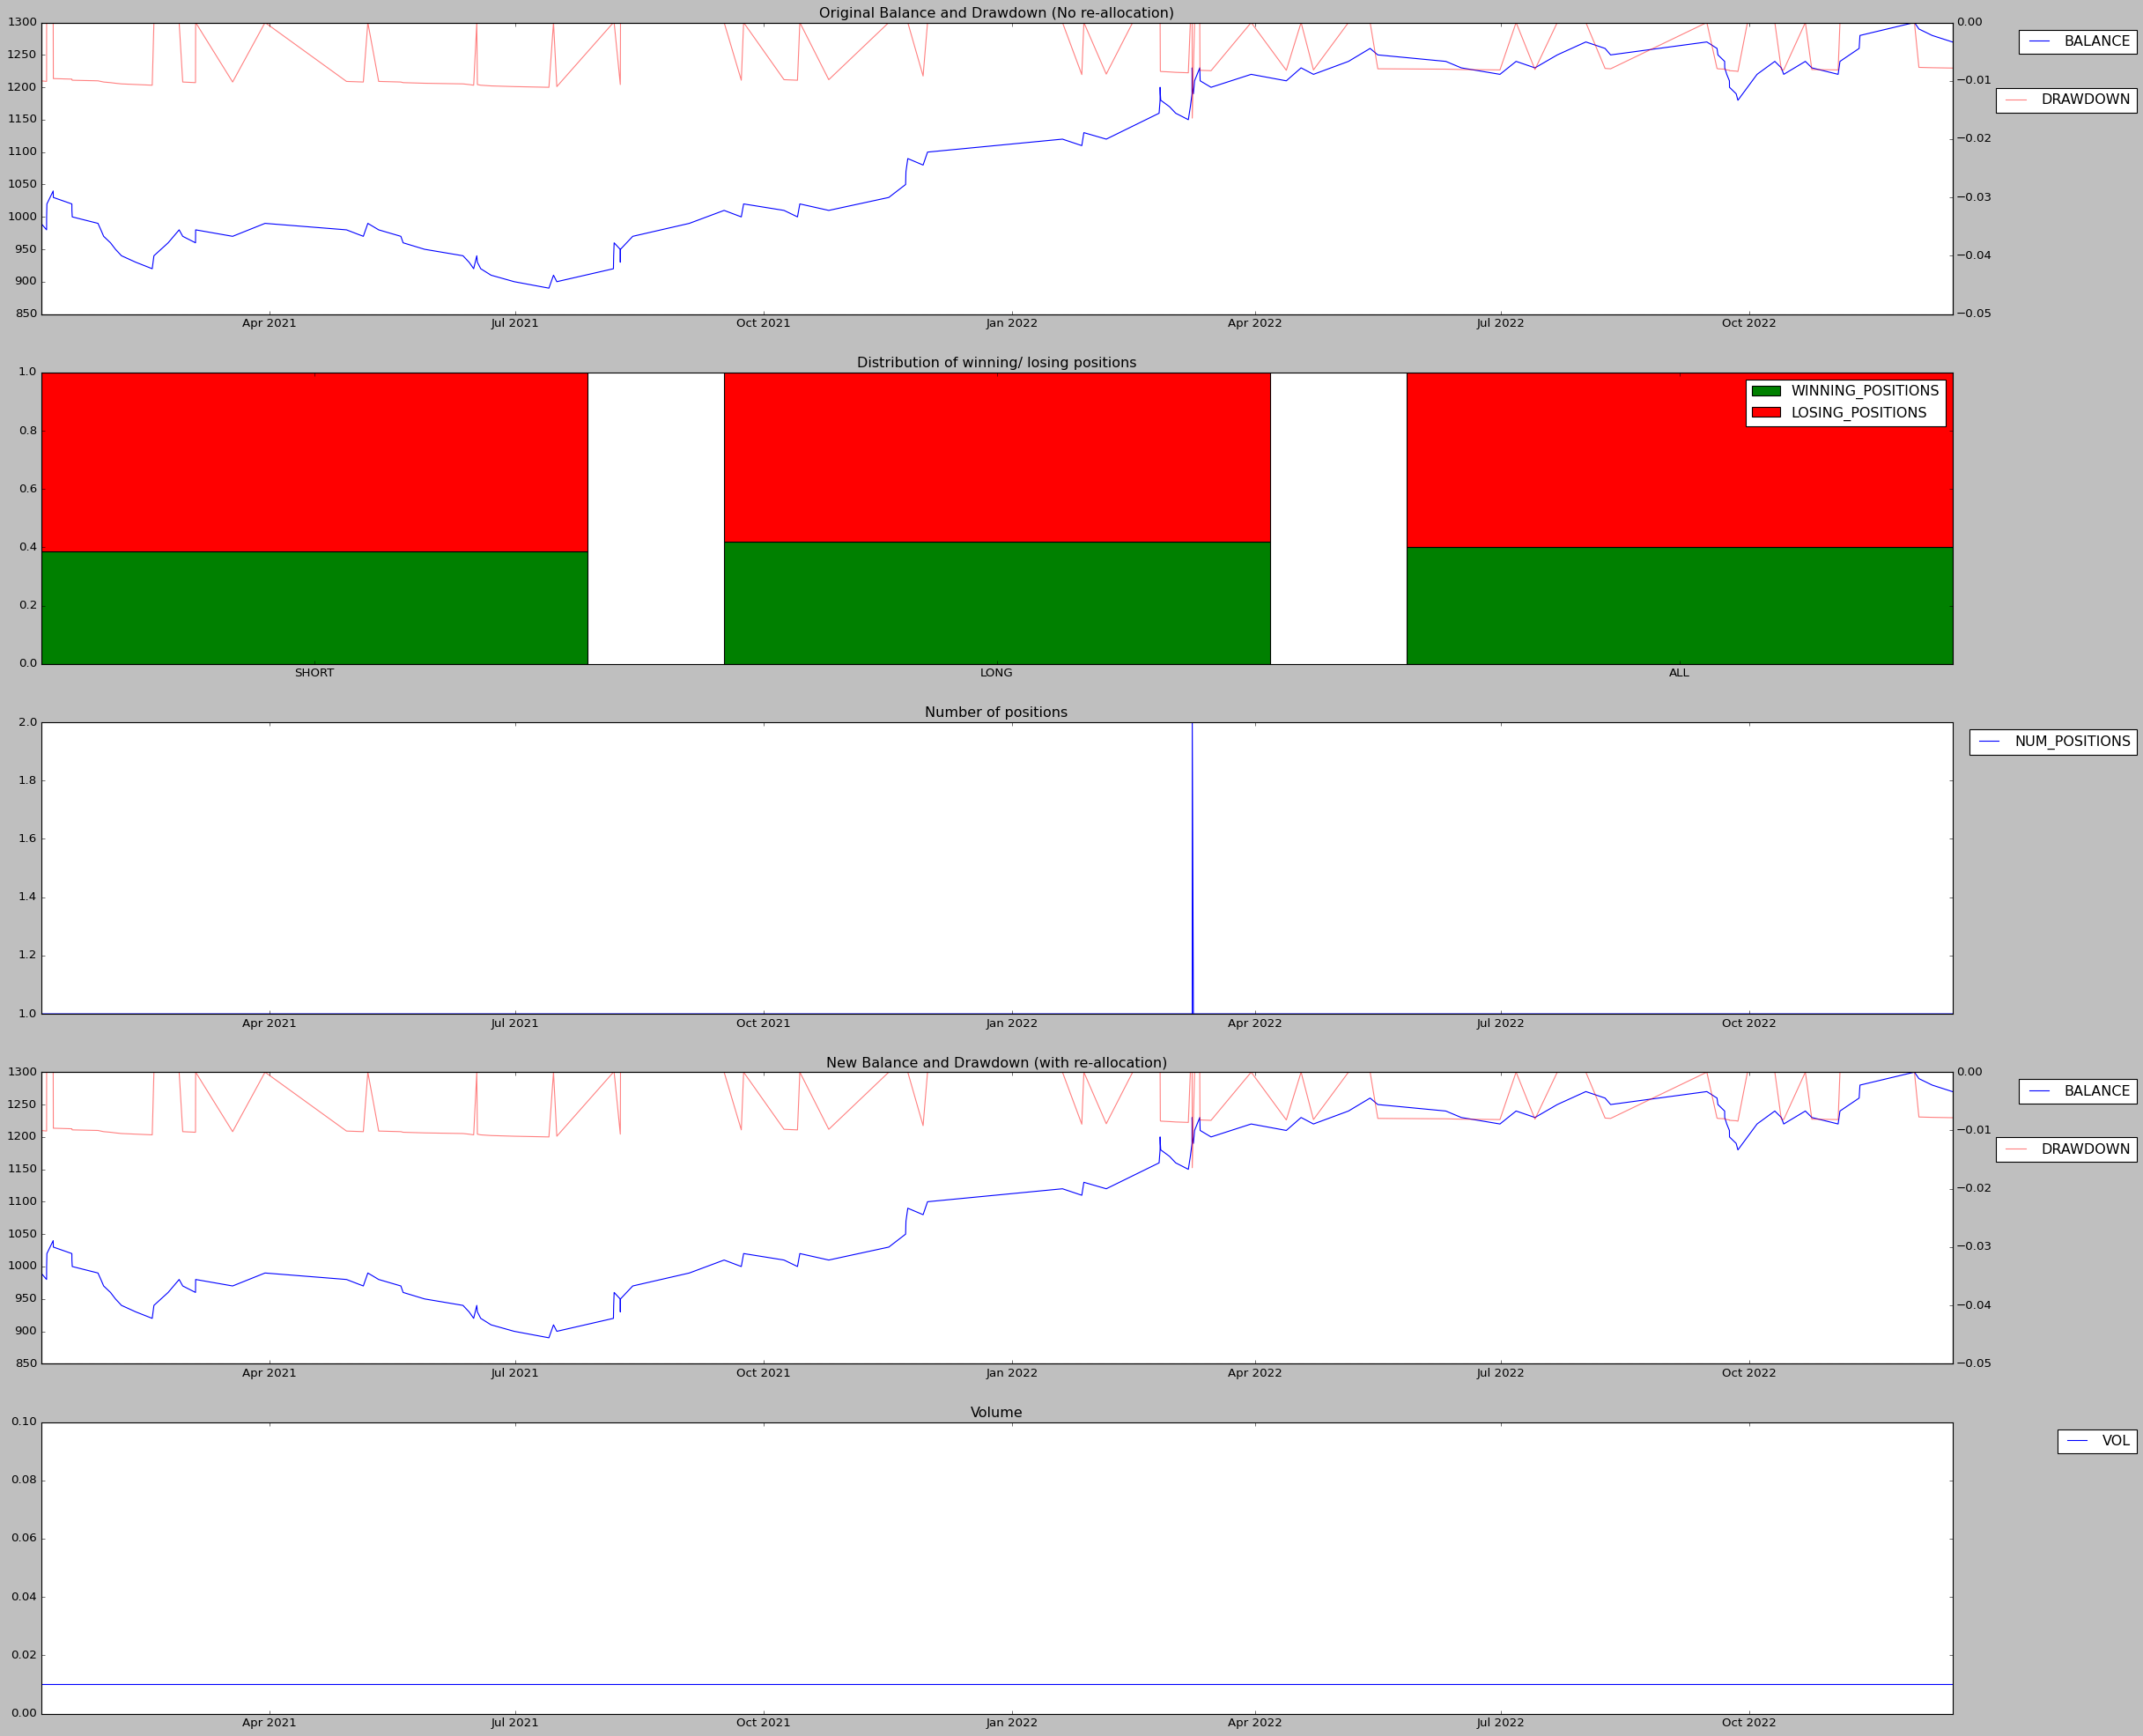

In [22]:
report_is = Backtest_report(alpha = alpha,
                            df_is = df_15_min_is.copy(),
                            base_SL = 10,
                            base_TP = 20,
                            max_existing_positions = 5,
                            init_vol = 0.01,
                            re_allocation = True,
                            incre_vol = 0.01,
                            max_vol = 0.1,
                            init_cap = 1000,
                            incre_cap = 2
                            )

report_is.display_report()

In [23]:
# report_is.prepare_report()

In [26]:
df_result_is = report_is.df_result_is
df_balance_is = report_is.df_balance_is
df_balance_new = report_is.df_balance_new


In [27]:
df_result_is['CLOSE'] = df_result_is['CLOSE_open'].copy()

In [28]:
df_summary = pd.concat(
    [
        pd.pivot_table(
            report_is.df_result_is[(report_is.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_is.df_result_is['SIGNAL'] != 0) & (report_is.df_result_is['PNL'] > 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        ),
        pd.pivot_table(
            report_is.df_result_is[(report_is.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_is.df_result_is['SIGNAL'] != 0) & (report_is.df_result_is['PNL'] < 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        )
    ],
    axis = 1
)

df_summary.columns = ['WINNING_POSITIONS', 'LOSING_POSITIONS']
df_summary.index = ['SHORT', 'LONG', 'ALL']
df_summary = df_summary.fillna(0)
df_summary['TOTAL_POSITIONS'] = df_summary['WINNING_POSITIONS'] + df_summary['LOSING_POSITIONS']

In [29]:
df_summary

,WINNING_POSITIONS,LOSING_POSITIONS,TOTAL_POSITIONS
SHORT,27,43,70
LONG,26,36,62
ALL,53,79,132


### Tuning

In [30]:
df_15_min_is['Ret(t+1)'] = df_15_min_is['Ret(t)'].shift(-1)

In [ ]:
df_15_min_is['GRP_Ret(t)'] = pd.qcut(df_15_min_is['Ret(t)'], q = 10)
df_15_min_is['GRP_Ret(t+1)'] = pd.qcut(df_15_min_is['Ret(t+1)'], q = 10)

In [32]:
df_state_proba = pd.pivot_table(
    df_15_min_is,
    index = 'GRP_Ret(t)',
    columns = 'GRP_Ret(t+1)',
    values = 'CLOSE',
    aggfunc = 'count',
    margins = True
)

df_state_proba = df_state_proba.apply(lambda x: x/x['All'], axis = 1)

In [33]:
df_state_proba

GRP_Ret(t+1),"(-2.931, -0.0541]","(-0.0541, -0.0147]","(-0.0147, 0.015]","(0.015, 0.0553]","(0.0553, 2.38]",All
GRP_Ret(t),,,,,,
"(-2.931, -0.0541]",0.227052,0.165186,0.159581,0.189086,0.259095,1.0
"(-0.0541, -0.0147]",0.166684,0.216288,0.220518,0.219672,0.176838,1.0
"(-0.0147, 0.015]",0.159704,0.220518,0.246959,0.210788,0.162031,1.0
"(0.015, 0.0553]",0.188769,0.214890,0.214679,0.208968,0.172695,1.0
"(0.0553, 2.38]",0.257720,0.183164,0.158206,0.171531,0.229378,1.0
All,0.199987,0.200008,0.199987,0.200008,0.200008,1.0


In [38]:
new_config = {
    'base_SL': 10, 
    'base_TP': 20,
    'DECISION_CUTOFF': {'ENTRY_BUY_CUTOFF': 0.05, 'ENTRY_SELL_CUTOFF': -0.05}
}

new_alpha = MCMC_strat_v1(config = new_config)

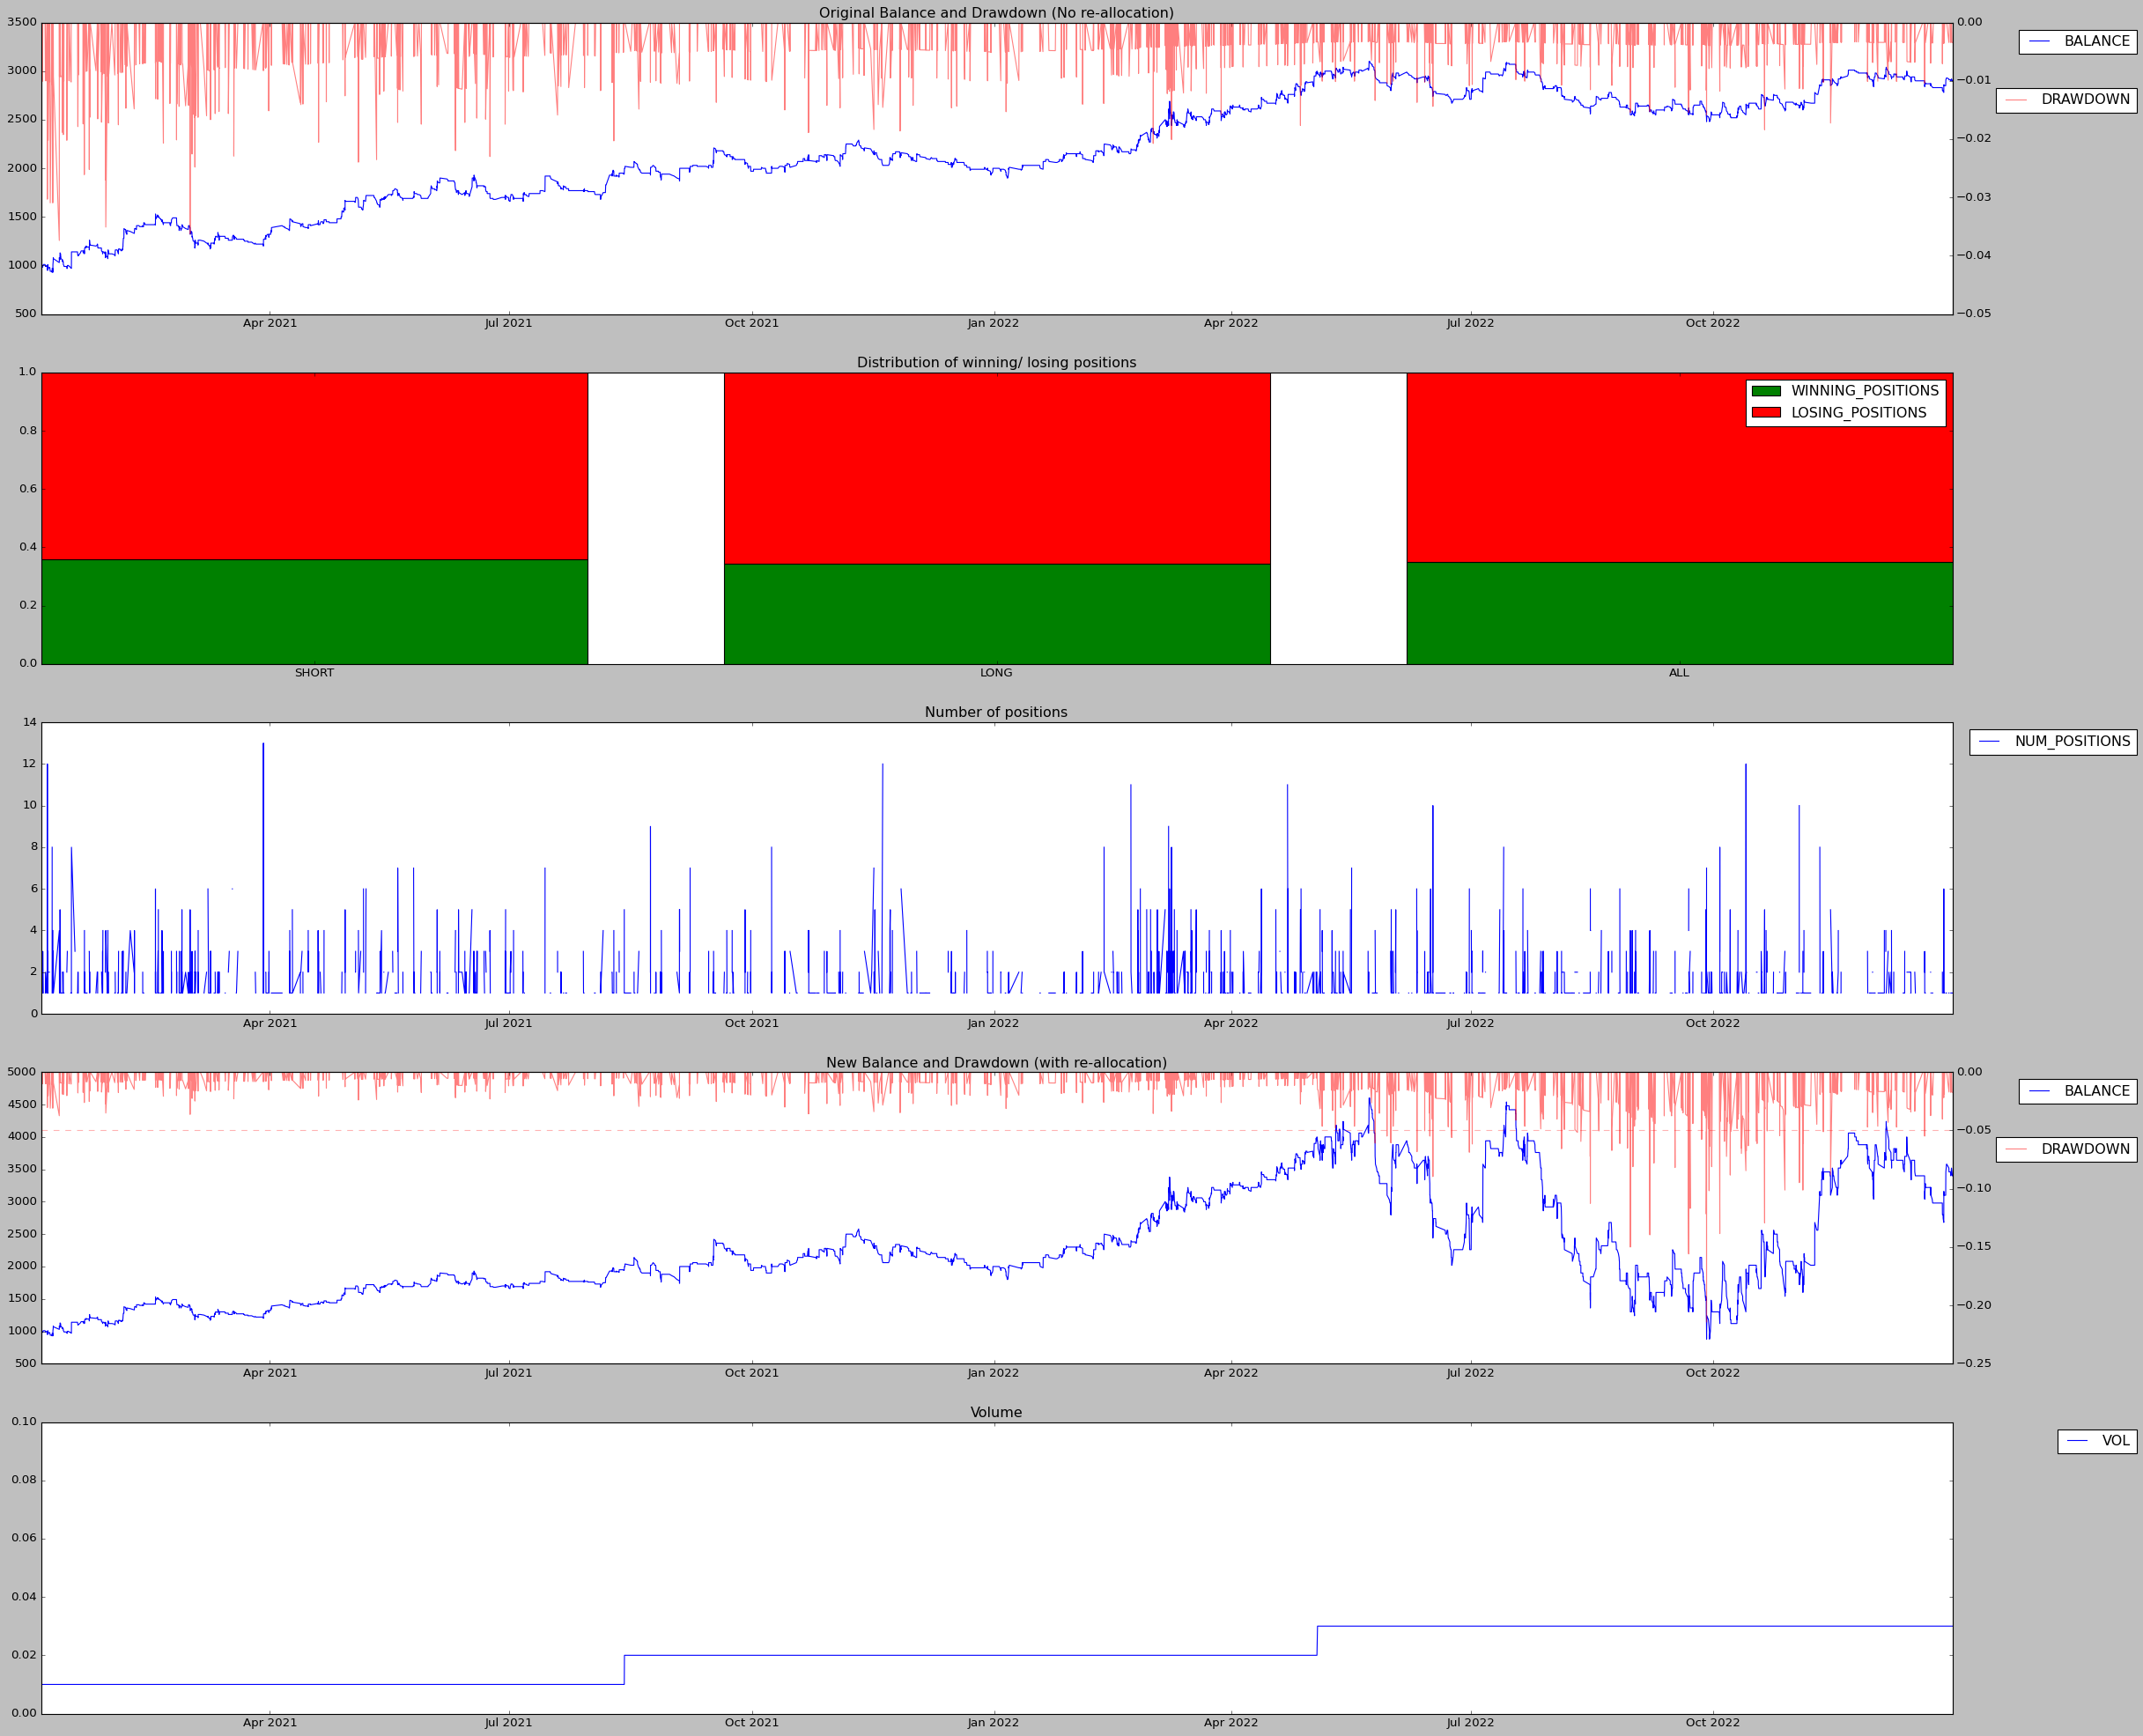

In [39]:
report_is = Backtest_report(alpha = new_alpha,
                            df_is = df_15_min_is.copy(),
                            base_SL = 10,
                            base_TP = 20,
                            max_existing_positions = 5,
                            init_vol = 0.01,
                            re_allocation = True,
                            incre_vol = 0.01,
                            max_vol = 0.1,
                            init_cap = 1000,
                            incre_cap = 2
                            )

report_is.display_report()

In [40]:
df_result_is = report_is.df_result_is
df_balance_is = report_is.df_balance_is
df_balance_new = report_is.df_balance_new

In [41]:
df_summary = pd.concat(
    [
        pd.pivot_table(
            report_is.df_result_is[(report_is.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_is.df_result_is['SIGNAL'] != 0) & (report_is.df_result_is['PNL'] > 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        ),
        pd.pivot_table(
            report_is.df_result_is[(report_is.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_is.df_result_is['SIGNAL'] != 0) & (report_is.df_result_is['PNL'] < 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        )
    ],
    axis = 1
)

df_summary.columns = ['WINNING_POSITIONS', 'LOSING_POSITIONS']
df_summary.index = ['SHORT', 'LONG', 'ALL']
df_summary = df_summary.fillna(0)
df_summary['TOTAL_POSITIONS'] = df_summary['WINNING_POSITIONS'] + df_summary['LOSING_POSITIONS']

df_summary

,WINNING_POSITIONS,LOSING_POSITIONS,TOTAL_POSITIONS
SHORT,663,1190,1853
LONG,644,1234,1878
ALL,1307,2424,3731


## Out-sample test

In [ ]:
# cnt = 0

# while cnt <= 10:
#     print('='*100)
#     print(cnt)
#     print('='*100)
#     id = random.randint(0, df_15_min_os.shape[0])
#     report_os = Backtest_report(alpha = alpha,
#                                 df_is = df_15_min_os[id - 50: id + 5000].copy(),
#                                 base_SL = 10,
#                                 base_TP = 20,
#                                 max_existing_positions = 5,
#                                 init_vol = 0.01,
#                                 re_allocation = True,
#                                 incre_vol = 0.01,
#                                 max_vol = 0.1,
#                                 init_cap = 1000,
#                                 incre_cap = 2
#                                 )

#     report_os.display_report()
#     cnt += 1

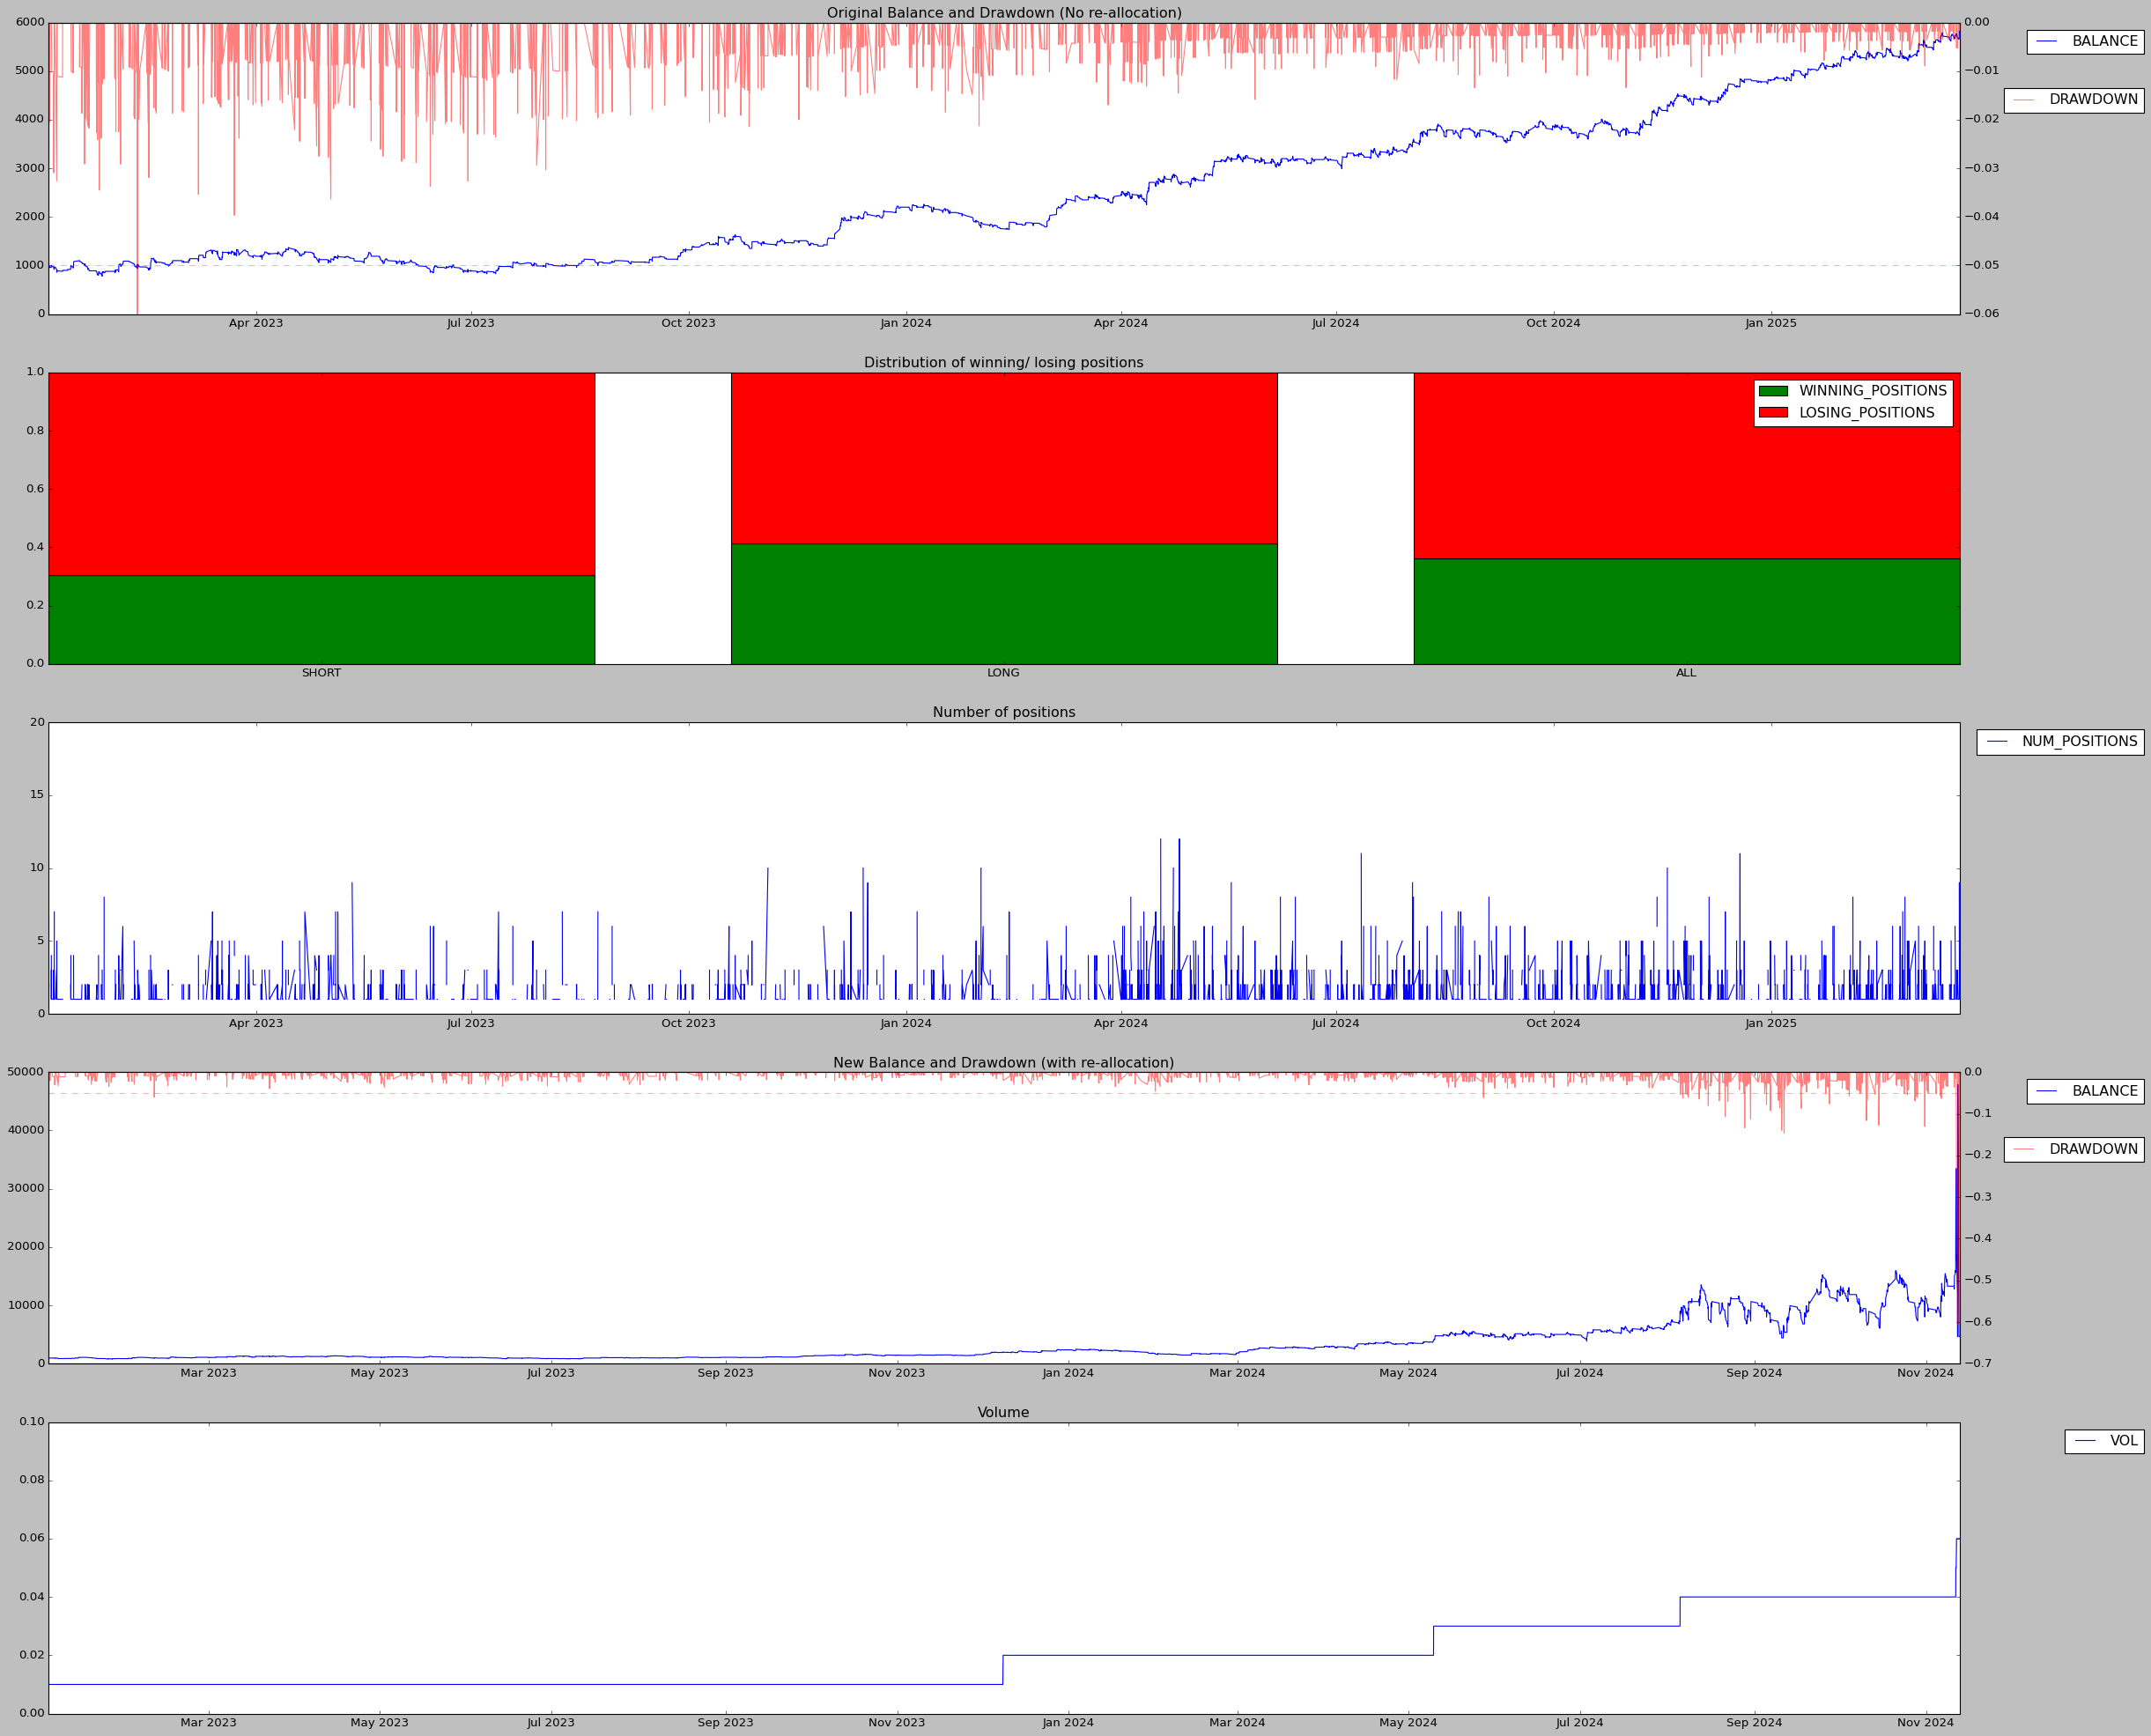

In [42]:
report_os = Backtest_report(alpha = new_alpha,
                            df_is = df_15_min_os.copy(),
                            base_SL = 10,
                            base_TP = 20,
                            max_existing_positions = 5,
                            init_vol = 0.01,
                            re_allocation = True,
                            incre_vol = 0.01,
                            max_vol = 0.1,
                            init_cap = 1000,
                            incre_cap = 2
                            )

report_os.display_report()

In [47]:
report_os.df_balance_new[report_os.df_balance_new['BALANCE'] > 0]

,PNL,COUNT,VOL,CUMULATIVE_PNL,BALANCE,DRAWDOWN,CUMULATIVE_DRAWDOWN
TIME_CLOSE_POSITION,,,,,,,
2023-01-03 02:45:00,-10.0,1.0,0.01,-10.0,990.0,-0.010000,-0.01
2023-01-03 03:00:00,-10.0,1.0,0.01,-20.0,980.0,-0.010101,-0.02
2023-01-03 07:30:00,10.0,2.0,0.01,-10.0,990.0,0.000000,0.00
2023-01-03 08:30:00,0.0,NaN,0.01,-10.0,990.0,0.000000,0.00
2023-01-03 11:30:00,-10.0,1.0,0.01,-20.0,980.0,-0.010101,-0.02
...,...,...,...,...,...,...,...
2024-11-12 13:15:00,-14400.0,2.0,0.06,18060.0,19060.0,-0.430365,18.06
2024-11-12 15:15:00,-7200.0,1.0,0.06,10860.0,11860.0,-0.377754,10.86
2024-11-12 15:30:00,0.0,NaN,0.06,10860.0,11860.0,0.000000,0.00


In [44]:
df_summary = pd.concat(
    [
        pd.pivot_table(
            report_os.df_result_is[(report_os.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_os.df_result_is['SIGNAL'] != 0) & (report_os.df_result_is['PNL'] > 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        ),
        pd.pivot_table(
            report_os.df_result_is[(report_os.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_os.df_result_is['SIGNAL'] != 0) & (report_os.df_result_is['PNL'] < 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        )
    ],
    axis = 1
)

df_summary.columns = ['WINNING_POSITIONS', 'LOSING_POSITIONS']
df_summary.index = ['SHORT', 'LONG', 'ALL']
df_summary = df_summary.fillna(0)
df_summary['TOTAL_POSITIONS'] = df_summary['WINNING_POSITIONS'] + df_summary['LOSING_POSITIONS']

In [45]:
df_summary

,WINNING_POSITIONS,LOSING_POSITIONS,TOTAL_POSITIONS
SHORT,838,1917,2755
LONG,1231,1742,2973
ALL,2069,3659,5728
